# Abstract dataset, dataloaders using fastai

In [1]:
#| default_exp nb_04b_data

## Load df

In [2]:
from fastai.vision.all import *

In [3]:
fs= (20,10)

In [4]:
from pathlib import Path

In [5]:
p_outx = Path("/media/dimi/TOSHIBA EXT/patched_images")
p_outy = Path("/media/dimi/TOSHIBA EXT/patched_masks")

In [6]:
df = pd.read_pickle("data/df_all_2022_10_06.pkl")
df.reset_index
df.loc[df["G"]=="2", "G"] = 2
df = df.loc[df["G"]!="1,2"]

In [7]:
df.G = df.G.astype("int")

In [8]:
df.G.unique()

array([2, 1, 3])

In [9]:
def split_df(df, η=0.8 # percentage training
            ):
    msk = np.random.rand(len(df)) < η
    return df[msk], df[~msk]

In [10]:
df_sampled = df.sample(n=100)
df_train, df_valid = split_df(df_sampled)

In [11]:
from fastai.vision.all import *

In [12]:
from torchvision import datasets, transforms

In [13]:
import PIL

## Dataset and dataloaders

In [14]:
def open_patch(fname, size=None):
    img = PIL.Image.open(fname).convert('RGB')
    if size is not None: img = img.resize((size, size))
    t = torch.Tensor(np.array(img))
    return t.permute(2,0,1).float()/255.0

In [15]:
class PatchedImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        images, target = self 
        if not isinstance(images[0], Tensor):
            tensors = [tensor(im).permute(2,0,1) for im in images]
        else: tensors = images
        line = tensors[0].new_zeros(tensors[0].shape[0], tensors[0].shape[1], 5)
        ts = [tensors[0]]+[torch.cat([line, t], dim=2) for t in tensors[1:]]
        return show_image(torch.cat(ts, dim=2), title=target, ctx=ctx, **kwargs)

In [16]:
#|export
from ml.nb_03_dataset import *

In [17]:
images_path = p_outx.str()+"/"+df.TMA_ID+"_"+df.TMASpot
image_path=images_path[0]

patch_paths = [image_path+"_"+str(i)+".png" for i in range(12)]

y = df.iloc[0]["G"]

images = [PILImage.create(p) for p in patch_paths]

s = PatchedImage(images, y)

s.show(figsize=(20,5));

In [18]:
#| export
class PatchedTransform(Transform):

    """Returns a batch of N patches with the specified target in dataframe"""
    
    def __init__(self, 
                 img_path, # Path with images   
                 df, # pandas dataframe
                 y_col, # df column for target
                 stime_col, #df column with survival time
                 N, # number of patches
                 mean, #mean for normalization
                 std,  #std for normalization
                 trfms=None #list of transforms
                ):
        self.img_path = img_path
        self.df = df
        self.df.reset_index()
        self.y_col = y_col
        self.stime_col = stime_col
        self.N = N
        self.mean, self.std = mean, std
        self.trfms = trfms
        self.img_ids = self.get_img_ids()
        
    def get_img_ids(self):
        col = self.img_path.str()+"/"+self.df.TMA_ID+"_"+self.df.TMASpot
        return col.tolist()
                
        
    def encodes(self, idx):
        img_id = self.img_ids[idx]
        y = self.df.iloc[idx][self.y_col]
        patch_paths = [img_id+"_"+str(i)+".png" for i in range(self.N)]
        patches = []
        
        
        
        for p in patch_paths:
            #img = PILImage.create(p)
            img = open_patch(p)
            
            if self.trfms is not None: 
                trnfs = torch.nn.Sequential(*self.trfms)
                img = trnfs(img)

            patches.append(img)
            
        #patches = torch.stack(patches, dim=0)
        
        return PatchedImage(patches,torch.LongTensor([y]).squeeze())
    #(TensorImage(patches), torch.Tensor([y]).squeeze())

In [19]:
train_tl= TfmdLists(range(len(df_train)), PatchedTransform(p_outx,df_train,"G","stime_10y_dom",12,mean_img,std_img ))
valid_tl= TfmdLists(range(len(df_valid)), PatchedTransform(p_outx,df_valid,"G","stime_10y_dom",12,mean_img,std_img ))

In [20]:
#train_tl= TfmdLists(range(len(df_train)), PatchedTransform(p_outx,df_train,"G","stime_10y_dom",12,\
#            mean_img,std_img, trfms= [transforms.Normalize(mean_img, std_img)]))

In [21]:
show_at(train_tl,0, figsize=fs);

In [22]:
dls = train_tl.dataloaders(bs=4)

In [23]:
@typedispatch
def show_batch(x:PatchedImage, y, samples, ctxs=None, max_n=12, nrows=None, ncols=1, figsize=None, **kwargs):
    x1 = torch.cat(x[0])
    x2 = x[1]
    x1 = x1.view(x2.shape[0],-1, x1.shape[1],x1.shape[2],x1.shape[3])
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(x[0][0].shape[0], nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): PatchedImage(x1[i], x2[i].item()).show(ctx=ctx)

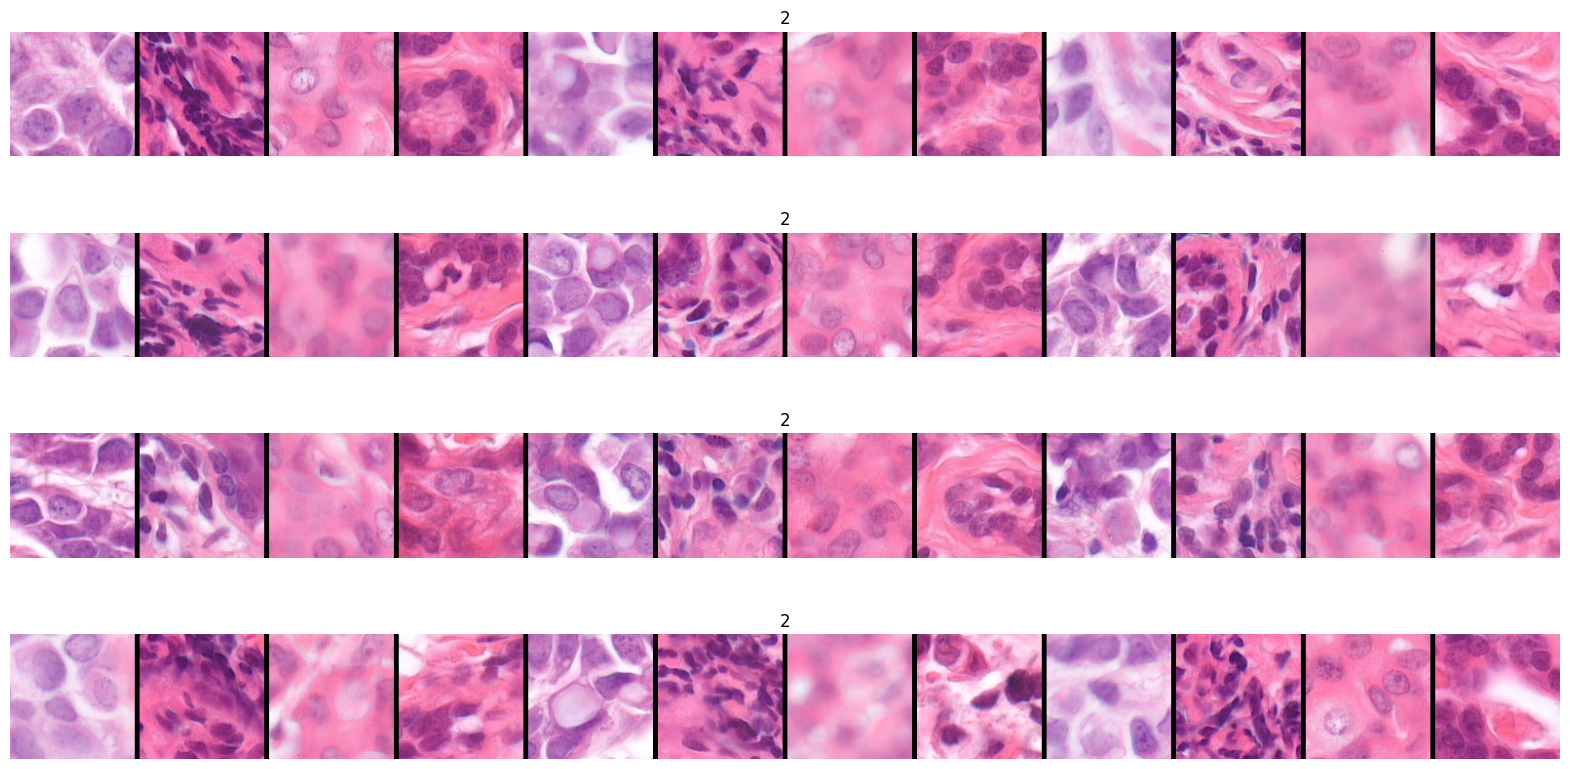

In [24]:
dls.show_batch(figsize=fs)

## Model

In [25]:
from torch import nn

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [27]:
class AdaptiveConcatPool2d(nn.Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`"
    def __init__(self, size=None):
        super(AdaptiveConcatPool2d, self).__init__()
        self.size = size or 1
        self.ap = nn.AdaptiveAvgPool2d(self.size)
        self.mp = nn.AdaptiveMaxPool2d(self.size)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

In [28]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, arch='resnext50_32x4d_ssl', n=3, pre=True):
        super().__init__()
        m = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', arch)
        self.enc = nn.Sequential(*list(m.children())[:-2])       
        nc = list(m.children())[-1].in_features
        self.head = nn.Sequential(AdaptiveConcatPool2d(),nn.Flatten(),nn.Linear(2*nc,512),
                            nn.Mish(),nn.BatchNorm1d(512), nn.Dropout(0.5),nn.Linear(512,n))

    def forward(self, *x):
        N, bs = len(x[0]), x[0][0].shape[0]
        x = torch.cat(x[0])
        x = x.view(bs,N, x.shape[1],x.shape[2],x.shape[3])
        shape = x.shape  #4, 12, 3, 128, 128
        bs, N, c, sz_x, sz_y = shape[0], shape[1], shape[2], shape[3], shape[4]
        x = x.view(-1, c, sz_x, sz_y)
        x = self.enc(x) #x: bs*N x C x 4 x 4
        shape = x.shape 
        x = x.view(-1,N,shape[1],shape[2],shape[3]).permute(0,2,1,3,4).contiguous()\
             .view(bs,shape[1],shape[2]*N,shape[3])  #x: bs x C x N*4 x 4
        x = self.head(x) #x: bs x N
        return x

In [29]:
model = NeuralNetwork().to(device)

Using cache found in /home/dimi/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


In [30]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [31]:
learn = Learner(dls, model= model, loss_func=loss_fn, metrics=accuracy)
learn.model = learn.model.cpu()

In [32]:
# CUDA_LAUNCH_BLOCKING=1.

In [33]:
#learn.lr_find()

In [34]:
Learner??

## Tuples

In [35]:
from fastai.vision.all import *

In [36]:
files = df.fn_x.tolist()

In [37]:
files[:5]

[Path('/media/dimi/TOSHIBA EXT/Dimitrij Original Images/TMA01_correctNames_SingleCores/12-E.tif'),
 Path('/media/dimi/TOSHIBA EXT/Dimitrij Original Images/TMA01_correctNames_SingleCores/2-D.tif'),
 Path('/media/dimi/TOSHIBA EXT/Dimitrij Original Images/TMA01_correctNames_SingleCores/5-A.tif'),
 Path('/media/dimi/TOSHIBA EXT/Dimitrij Original Images/TMA01_correctNames_SingleCores/10-A.tif'),
 Path('/media/dimi/TOSHIBA EXT/Dimitrij Original Images/TMA01_correctNames_SingleCores/10-B.tif')]

In [38]:
files[0]

Path('/media/dimi/TOSHIBA EXT/Dimitrij Original Images/TMA01_correctNames_SingleCores/12-E.tif')

In [329]:
def file2patches(f):
    #if f is not Path: f = Path(f)
    tmp = df[df.fn_x==f]
    image_path = p_outx.str()+"/"+tmp.TMA_ID+"_"+tmp.TMASpot
    return [image_path.item()+"_"+str(i)+".png" for i in range(12)]

In [330]:
file2patches(files[0])

['/media/dimi/TOSHIBA EXT/patched_images/TMA1_E12_0.png',
 '/media/dimi/TOSHIBA EXT/patched_images/TMA1_E12_1.png',
 '/media/dimi/TOSHIBA EXT/patched_images/TMA1_E12_2.png',
 '/media/dimi/TOSHIBA EXT/patched_images/TMA1_E12_3.png',
 '/media/dimi/TOSHIBA EXT/patched_images/TMA1_E12_4.png',
 '/media/dimi/TOSHIBA EXT/patched_images/TMA1_E12_5.png',
 '/media/dimi/TOSHIBA EXT/patched_images/TMA1_E12_6.png',
 '/media/dimi/TOSHIBA EXT/patched_images/TMA1_E12_7.png',
 '/media/dimi/TOSHIBA EXT/patched_images/TMA1_E12_8.png',
 '/media/dimi/TOSHIBA EXT/patched_images/TMA1_E12_9.png',
 '/media/dimi/TOSHIBA EXT/patched_images/TMA1_E12_10.png',
 '/media/dimi/TOSHIBA EXT/patched_images/TMA1_E12_11.png']

In [331]:
def file2y(f):
    return df[df.fn_x==f]["G"].item()

In [332]:
file2y(files[0])

2

In [354]:
def open_patch(fname, size=None):
    img = PIL.Image.open(fname).convert('RGB')
    if size is not None: img = img.resize((size, size))
    t = torch.Tensor(np.array(img))
    return t.permute(2,0,1).float()/255.0

In [430]:
def topatch(fn): 
    pts = file2patches(fn)
    x1 = torch.cat([open_patch(f) for f in pts[:4]], dim=2)
    x2 = torch.cat([open_patch(f) for f in pts[4:8]], dim=2)
    x3 = torch.cat([open_patch(f) for f in pts[8:]], dim=2)
    return torch.cat([x1,x2,x3], dim=1)

In [431]:
class PatchTuple(fastuple):
    @classmethod
    def create(cls, fn): 
        return cls(tuple(topatch(fn)))
     
    def show(self, ctx=None, **kwargs): 
        image = self 
        if not isinstance(image[0], Tensor):
            t = [tensor(im).permute(2,0,1)/255. for im in images]
        else: t = image[0]
        return show_image(t, ctx=ctx, **kwargs)

In [432]:
files[0]

Path('/media/dimi/TOSHIBA EXT/Dimitrij Original Images/TMA01_correctNames_SingleCores/12-E.tif')

In [433]:
img = PatchTuple.create(files[0])
tst = ToTensor()(img)
type(tst[0])

torch.Tensor

In [434]:
tst[0].shape

torch.Size([384, 512])

In [435]:
tst = ToTensor()(img)
tst.show(figsize=(5,5));

In [436]:
def PatchTupleBlock(): return TransformBlock(type_tfms=PatchTuple.create, batch_tfms=IntToFloatTensor)

In [437]:
files = L(files)

In [472]:
splits = RandomSplitter()(files)

In [473]:
splits_files = [files[splits[i]] for i in range(2)]
splits_sets = mapped(set, splits_files)

In [474]:
def get_split(f):
    for i,s in enumerate(splits_sets):
        if f in s: return i
    raise ValueError(f'File {f} is not presented in any split.')

In [475]:
label_func = file2y

In [476]:
labels = np.array([1,2,3])
labels

array([1, 2, 3])

In [477]:
splbl2files = [{l: [f for f in s if label_func(f) == l] for l in labels} for s in splits_sets]

In [478]:
def splitter(items): 
    def get_split_files(i): return [j for j,f in enumerate(items) if get_split(f)==i]
    return get_split_files(0),get_split_files(1)

In [479]:
# def get_tuples(files): return [[f, file2y(f)] for f in files]

In [480]:
def get_tuples(files): return files# [[f, file2y(f)] for f in files]

In [481]:
#def get_split_files(i): return [j for j,(f,y) in enumerate(items) if get_split(f)==i]

In [482]:
#filesl = [str(f) for f in files]

In [483]:
tt= get_tuples(files)

In [484]:
tt[0]

Path('/media/dimi/TOSHIBA EXT/Dimitrij Original Images/TMA01_correctNames_SingleCores/12-E.tif')

In [485]:
items =tt[:10]

In [486]:
[j for j,(f,y) in enumerate(items)]

TypeError: cannot unpack non-iterable PosixPath object

In [487]:
get_split_files(1)

TypeError: cannot unpack non-iterable PosixPath object

In [488]:
tt[0][0]

TypeError: 'PosixPath' object is not subscriptable

In [489]:
def get_x(t): return t
def get_y(t): return file2y(t)

In [490]:
patches = DataBlock(
    blocks=(PatchTupleBlock, CategoryBlock),
    get_items=get_tuples,
    get_x=get_x, 
    get_y=get_y,
    splitter=splitter
)

In [491]:
dls = patches.dataloaders(files)

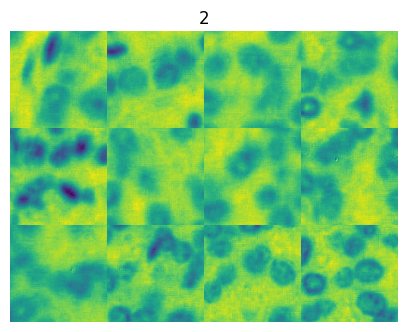

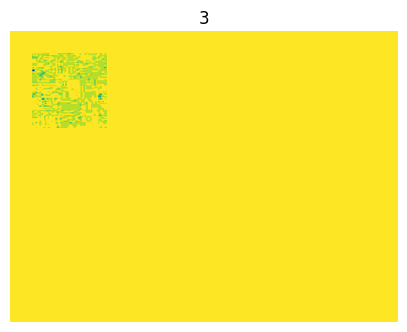

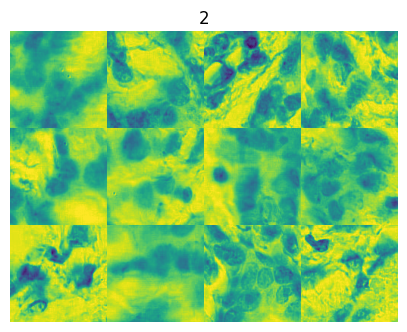

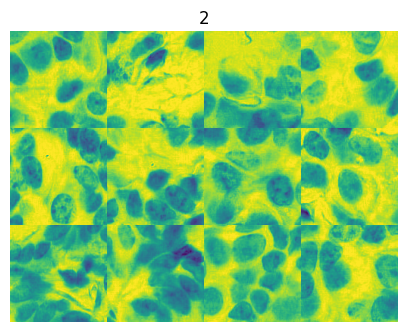

In [492]:
dls.show_batch()